[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os

# Directly set your Roboflow API key
os.environ["ROBOFLOW_API_KEY"] = "wGYGwTjglhST7mybt9qF"


### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Apr 14 09:39:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 68.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-14 09:42:48--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.002s  

2025-04-14 09:42:48 (61.8 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

## Download dataset from Roboflow Universe

In [7]:
from roboflow import Roboflow

# Initialize Roboflow
rf = Roboflow(api_key="wGYGwTjglhST7mybt9qF")

# Load your workspace and project
project = rf.workspace("da-mec7y").project("cataract-finder-nups1")

# Get the version you want (e.g., version 1) and specify format as 'yolov12'
dataset = project.version(1).download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cataract-finder-1 in yolov12:: 100%|██████████| 1073/1073 [00:00<00:00, 2181.60it/s]


In [8]:
!ls {dataset.location}

data.yaml  README.roboflow.txt	test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['cataract', 'normal']

roboflow:
  workspace: da-mec7y
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [11]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=50)

New https://pypi.org/project/ultralytics/8.3.107 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/cataract-finder-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

100%|██████████| 755k/755k [00:00<00:00, 130MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 287MB/s]


AMP: checks passed ✅


train: Scanning /content/cataract-finder-1/train/labels... 388 images, 0 backgrounds, 0 corrupt: 100%|██████████| 388/388 [00:00<00:00, 2059.22it/s]


train: New cache created: /content/cataract-finder-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/cataract-finder-1/valid/labels... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<00:00, 1719.83it/s]

val: New cache created: /content/cataract-finder-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.78G      3.023      4.355      4.244         11        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         92         94   0.000906      0.376    0.00183   0.000588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.85G      2.895      4.211      4.108          6        640: 100%|██████████| 25/25 [00:17<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         92         94   0.000726      0.321    0.00222    0.00097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.72G      2.898      3.845      3.799          7        640: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         92         94    0.00109      0.372     0.0333    0.00838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.87G      2.789      3.581      3.494          8        640: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         92         94    0.00752      0.244     0.0355     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.85G      2.754      3.337      3.333          9        640: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         92         94       0.73     0.0222     0.0285    0.00495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.88G      2.797      3.127      3.319         12        640: 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         92         94      0.287      0.374      0.242      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.89G      2.785      2.948      3.299          7        640: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         92         94      0.442      0.352       0.36      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.72G      2.684      2.743      3.207          5        640: 100%|██████████| 25/25 [00:15<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         92         94      0.286      0.443      0.333      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.85G       2.58      2.578      3.154          7        640: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         92         94      0.562      0.354       0.38      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.88G      2.484      2.458      3.023         12        640: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         92         94      0.221      0.407      0.257      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.89G      2.353      2.346      2.939          4        640: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         92         94      0.613      0.444      0.549      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.89G      2.317      2.131       2.85         13        640: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         92         94      0.654      0.663      0.676      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.85G      2.224      2.094      2.816          5        640: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         92         94      0.562      0.691      0.649      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.88G      2.209      2.146      2.786         10        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         92         94      0.574      0.647      0.631      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.89G      2.027      1.917      2.678          9        640: 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         92         94      0.729      0.762      0.795      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.88G      2.016      1.849      2.635          6        640: 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         92         94      0.845      0.657      0.776      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.85G      1.982      1.819      2.571          7        640: 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         92         94       0.81      0.868      0.888      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.88G      1.877      1.754      2.473          9        640: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         92         94      0.836      0.818      0.888       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.89G      1.816      1.673      2.431          9        640: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         92         94      0.804      0.838      0.877      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.72G      1.756      1.602      2.357         12        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         92         94      0.846      0.803      0.892      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.85G      1.755      1.585      2.391          6        640: 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         92         94      0.863      0.865      0.903      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.88G      1.676      1.496      2.329          9        640: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         92         94      0.902      0.819      0.884      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.89G      1.623      1.465      2.245         10        640: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         92         94      0.907      0.793      0.905       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.72G        1.6      1.392      2.212          8        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         92         94      0.926      0.843      0.913       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.85G      1.567      1.339      2.158          7        640: 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         92         94      0.928      0.862      0.931       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.88G       1.54      1.279      2.162         13        640: 100%|██████████| 25/25 [00:15<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         92         94      0.988      0.837      0.927      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.88G      1.544      1.354      2.105          7        640: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         92         94      0.931      0.873      0.939      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.89G      1.504      1.278      2.114         11        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         92         94      0.907      0.889      0.916      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.85G       1.48      1.211      2.083         11        640: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         92         94      0.896       0.92      0.926      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.88G      1.523      1.243      2.116         11        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         92         94      0.946      0.896      0.952      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.88G      1.435      1.135      2.051          7        640: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         92         94      0.933      0.909      0.933      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.72G      1.454      1.218      2.056          6        640: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         92         94      0.915      0.896      0.925      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.85G      1.411      1.116      2.004         10        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         92         94      0.873      0.907      0.916      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.88G      1.365      1.095      1.948          5        640: 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         92         94      0.939      0.916      0.942      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.89G      1.328      1.082      1.941         13        640: 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         92         94       0.97      0.845      0.937      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.72G      1.296      1.063      1.919         12        640: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         92         94      0.966      0.936      0.936      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.85G      1.339      1.088      1.937         11        640: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         92         94      0.953      0.858      0.929      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.88G      1.381      1.111      1.964          9        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all         92         94      0.932      0.934      0.938      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.89G      1.292      1.059      1.902         13        640: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         92         94      0.937      0.932      0.937      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.88G      1.247      1.022      1.863         10        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all         92         94      0.969      0.933      0.953      0.614


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.85G      1.168     0.9214        1.8          5        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         92         94      0.959      0.935      0.936      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.88G       1.12     0.8264      1.788          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         92         94       0.93      0.924      0.939      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.88G      1.069     0.8071      1.739          4        640: 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         92         94      0.981      0.929      0.941      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.88G      1.088     0.7838      1.771          4        640: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         92         94      0.979      0.936      0.944      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.85G      1.054     0.7954      1.735          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         92         94      0.974      0.939      0.942      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.88G      1.063     0.7767      1.754          4        640: 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         92         94      0.975      0.939      0.942      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.88G      1.035     0.7867      1.736          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         92         94      0.975      0.939       0.94      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.72G      1.025     0.7703      1.693          4        640: 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         92         94      0.979      0.939      0.941      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.85G      1.031      0.755        1.7          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         92         94      0.972      0.937       0.94      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.88G      1.018     0.7342      1.701          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         92         94      0.985      0.934      0.941      0.626



50 epochs completed in 0.264 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


                   all         92         94      0.976      0.939      0.942      0.644
              cataract         45         45      0.978          1      0.995      0.731
                normal         49         49      0.973      0.878      0.888      0.558
Speed: 0.2ms preprocess, 7.4ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1000.jpg
confusion_matrix_normalized.png			   train_batch1001.jpg
confusion_matrix.png				   train_batch1002.jpg
events.out.tfevents.1744623897.860eaf10b620.177.0  train_batch1.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


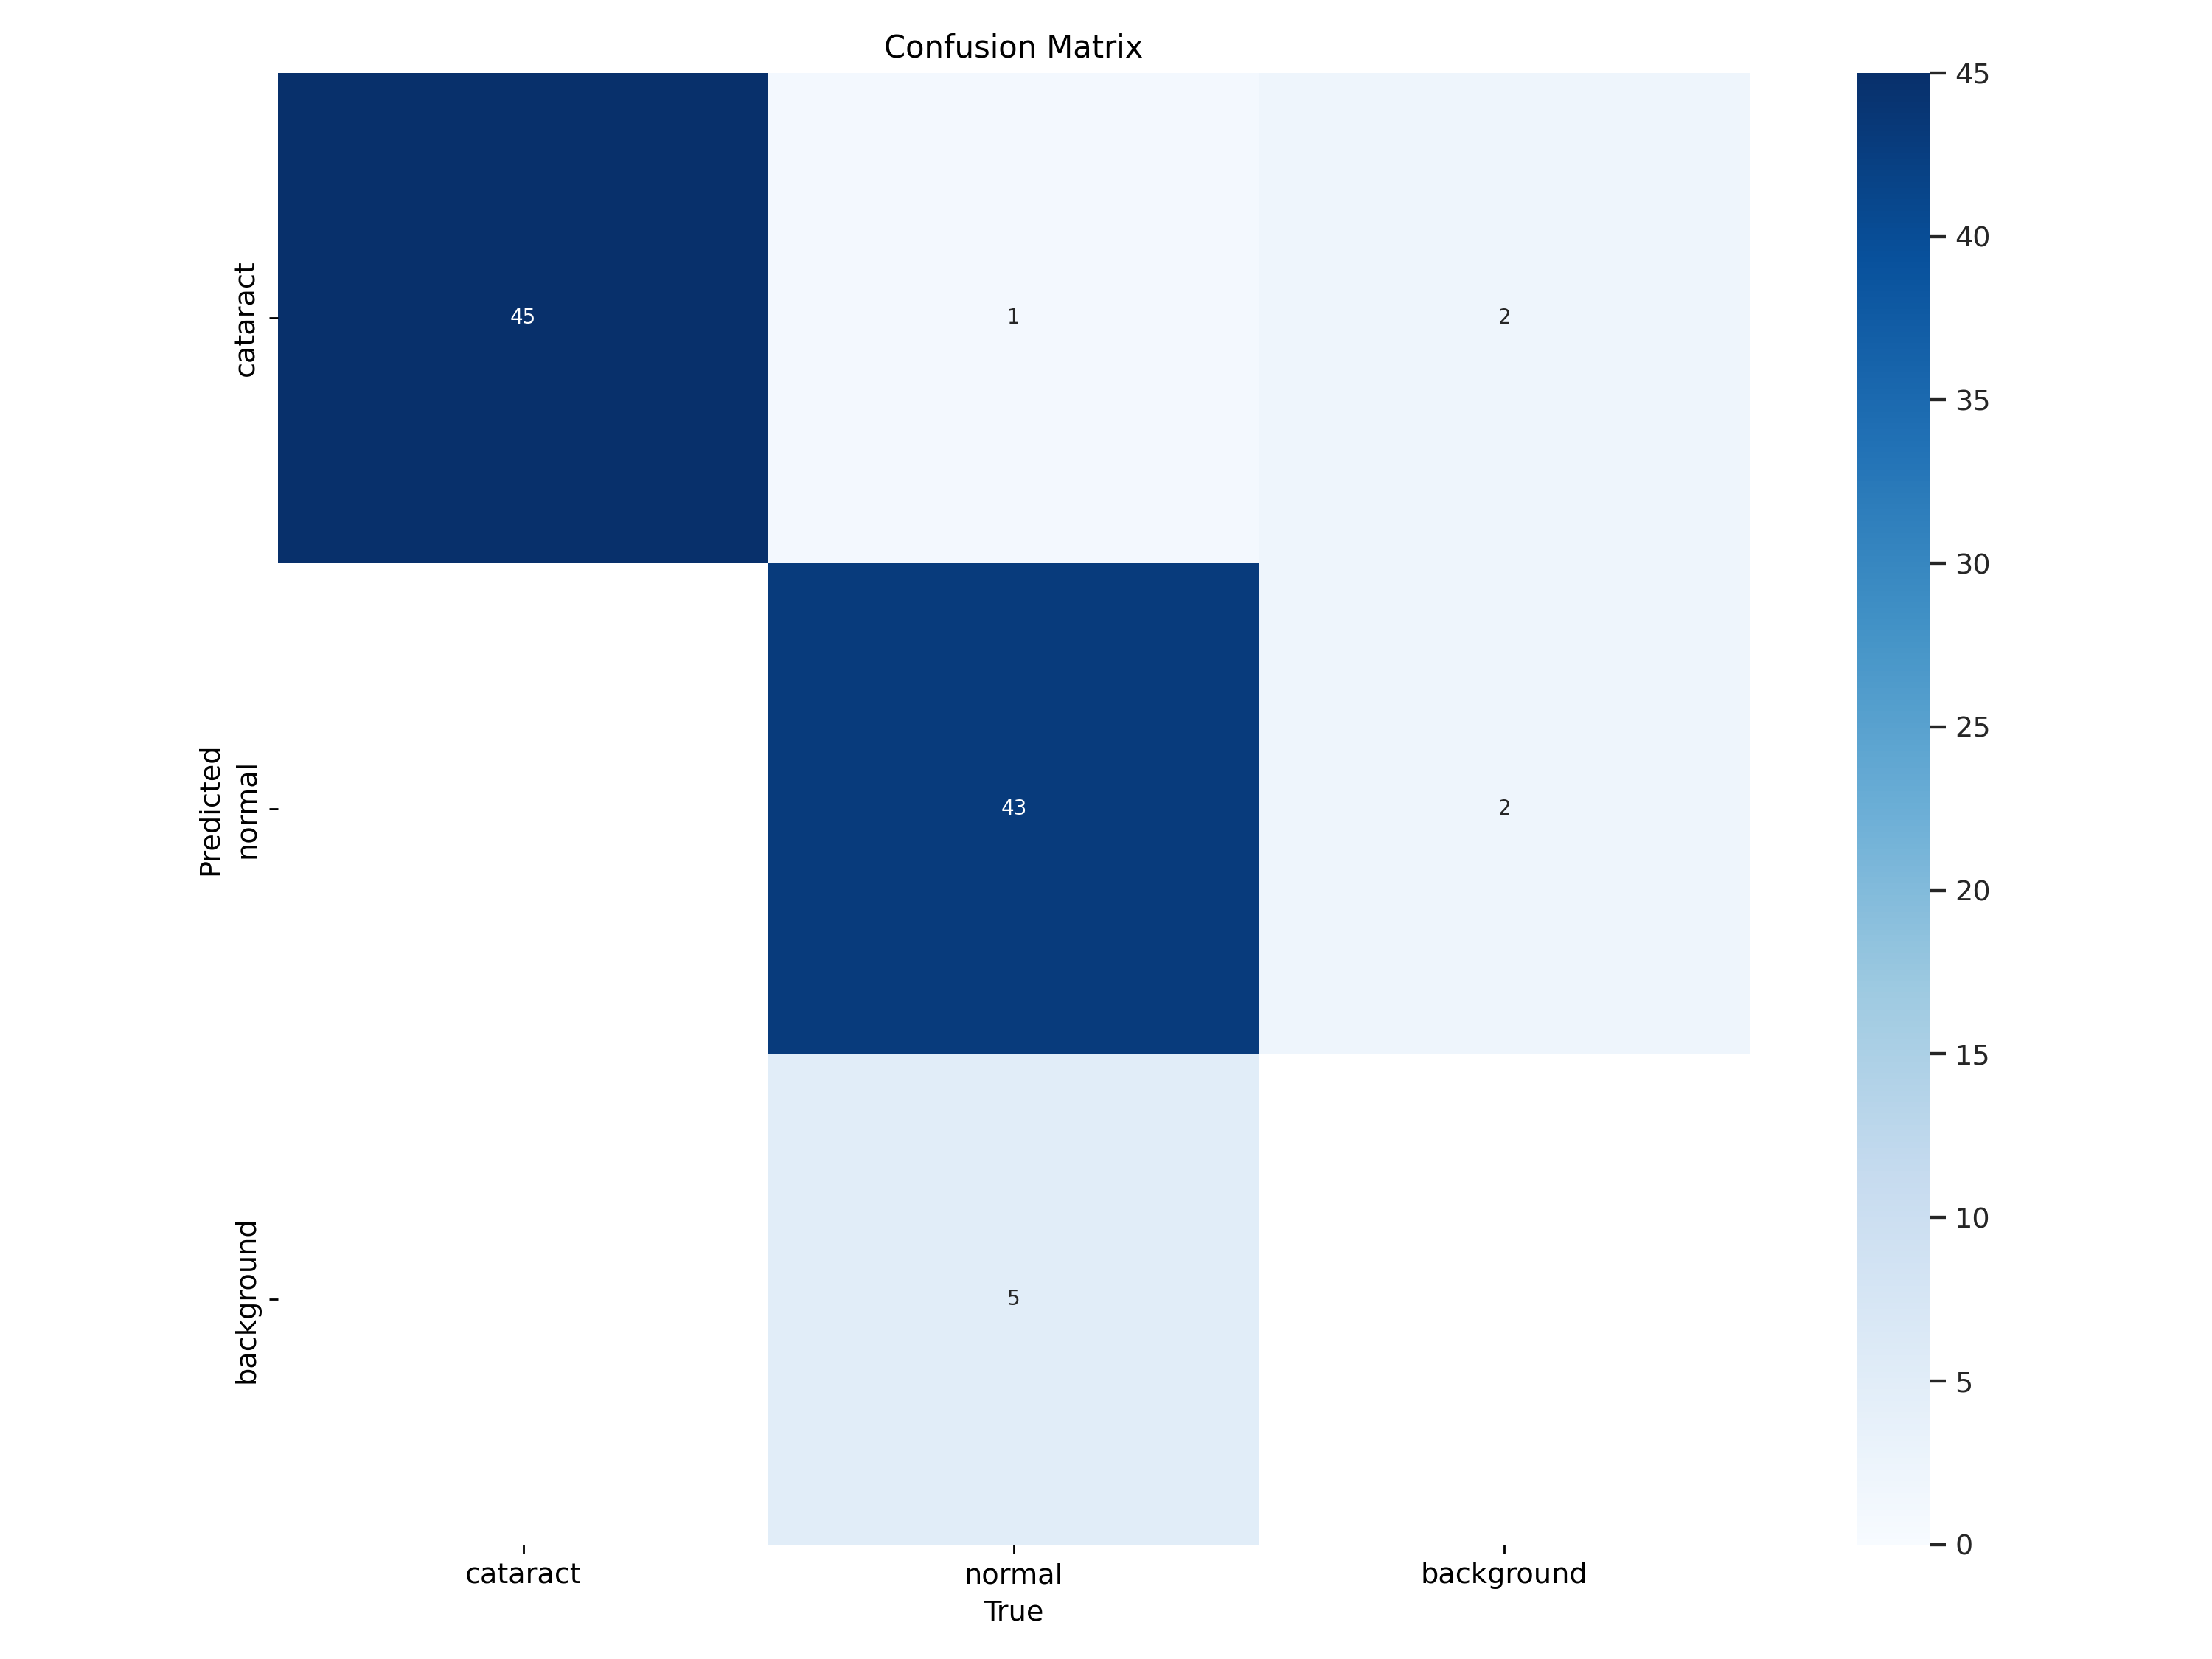

In [13]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

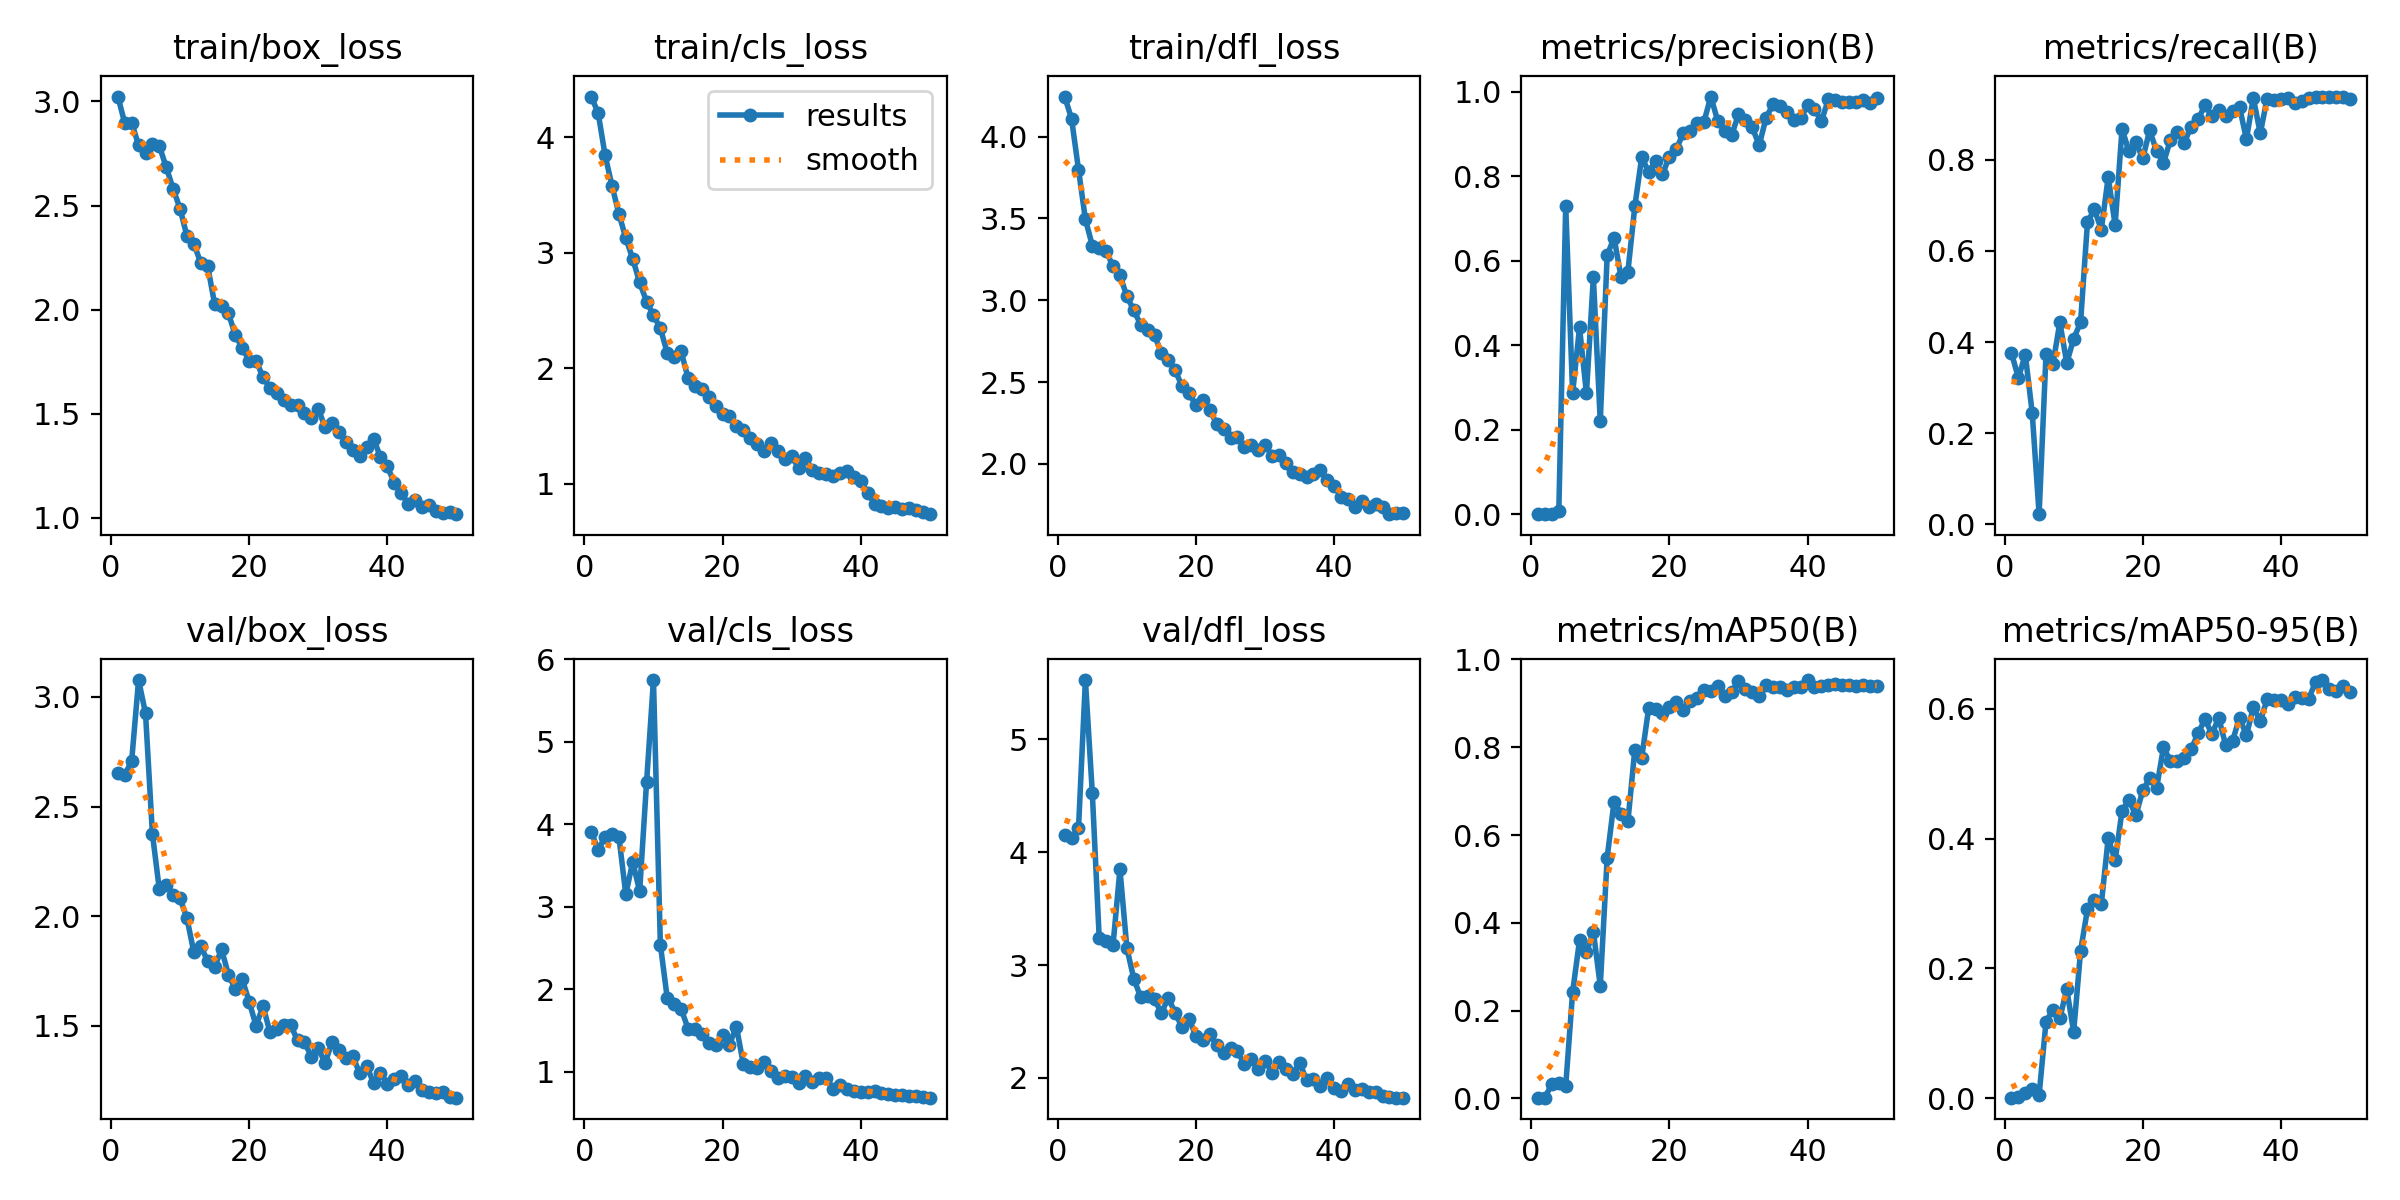

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [15]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['cataract', 'normal']

In [16]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [17]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6306544776229104
mAP 50 0.9117384773594416
mAP 75 0.8100598266664585


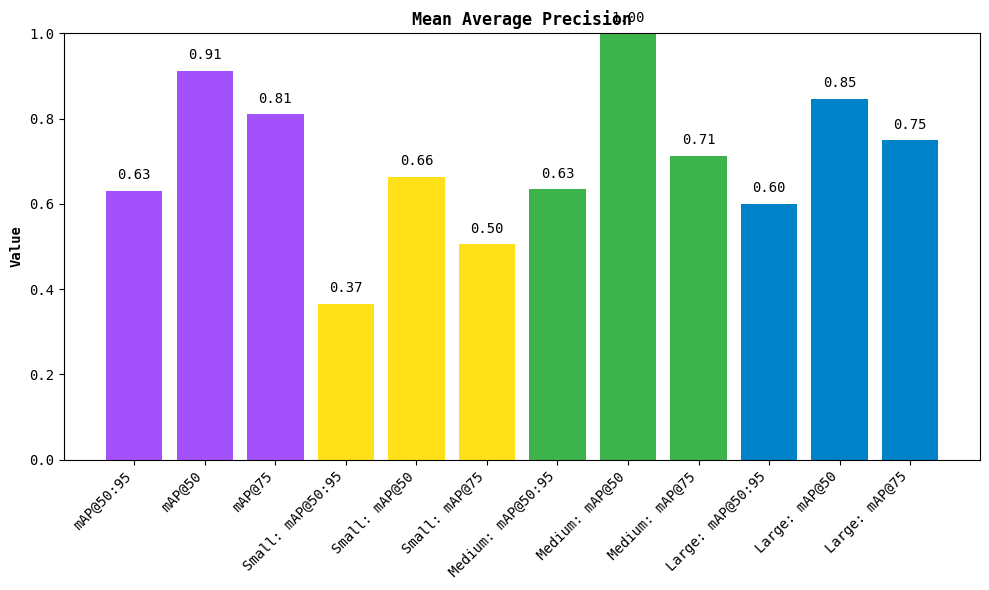

In [18]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [19]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

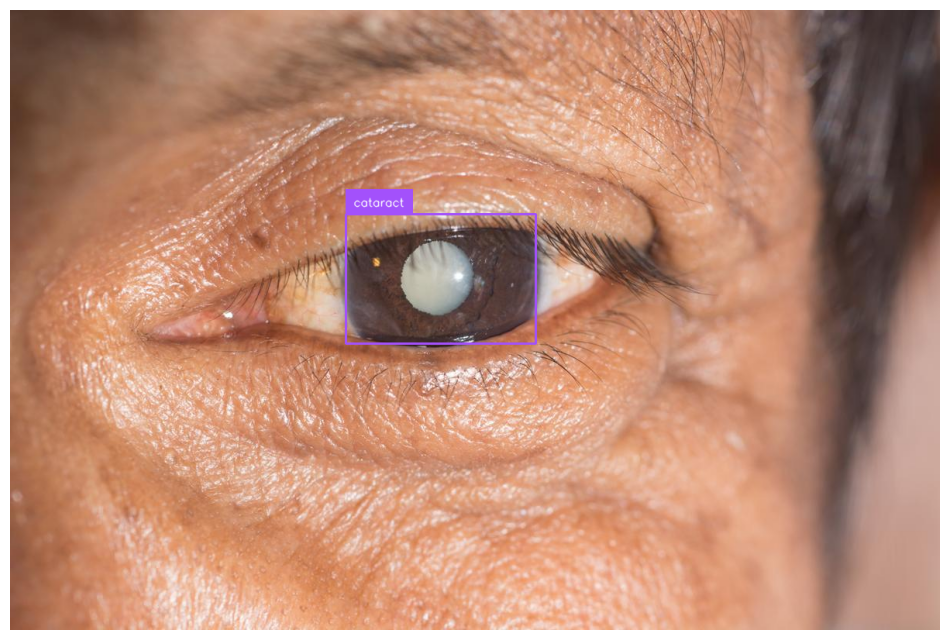

In [20]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [31]:
print(results)  # Print the full structure of the result


tensor([-2.4679,  0.9305], grad_fn=<SelectBackward0>)


In [22]:
import os
import cv2

output_dir = "/content/cropped_data"
os.makedirs(output_dir, exist_ok=True)

for idx in range(50):  # adjust this number as needed
    image_path, image, target = ds[idx]
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results).with_nms()

    for i in range(len(detections)):
        box = detections.xyxy[i]
        class_id = int(detections.class_id[i])

        # Optional: use proper class names if available
        class_name = model.model.names[class_id] if hasattr(model.model, "names") else f"class_{class_id}"

        x1, y1, x2, y2 = [int(v) for v in box]
        cropped = image[y1:y2, x1:x2]

        class_folder = os.path.join(output_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)

        out_path = os.path.join(class_folder, f"{idx}_{i}.jpg")
        cv2.imwrite(out_path, cropped)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset from folders
dataset = datasets.ImageFolder("/content/cropped_data", transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Use a pre-trained model like ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: cataract, normal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.7MB/s]


Epoch [1/10], Loss: 2.6021
Epoch [2/10], Loss: 0.4047
Epoch [3/10], Loss: 0.2607
Epoch [4/10], Loss: 0.1607
Epoch [5/10], Loss: 0.0852
Epoch [6/10], Loss: 0.0898
Epoch [7/10], Loss: 0.0258
Epoch [8/10], Loss: 0.1188
Epoch [9/10], Loss: 0.0277
Epoch [10/10], Loss: 0.0413


In [24]:
torch.save(model.state_dict(), "/content/cropped_data/cnn_cataract_classifier.pth")


In [13]:
import torch
from torchvision import transforms, models
from PIL import Image

# Define the same transforms used in training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the ResNet18 model, without pretrained weights
model = models.resnet18(weights=None)  # No pretrained weights
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes for severity (Severe, Moderate, Mild, Normal)

# Load the pre-trained weights except for the final fully connected layer
pretrained_weights = torch.load("/content/cropped_data/cnn_cataract_classifier.pth", map_location=torch.device('cpu'))

# Remove the keys related to the fully connected layer (as its output size doesn't match)
pretrained_weights = {k: v for k, v in pretrained_weights.items() if 'fc' not in k}

# Load the weights into the model (skip the fc layer weights)
model.load_state_dict(pretrained_weights, strict=False)
model.eval()

# Define class names for severity classification
class_names = ['Severe', 'Moderate', 'Mild', 'Normal']

# Function to test a single image
def classify_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)  # Get the class with the highest score

    return class_names[predicted.item()]

# Example usage for the specified image
test_image_path = "/content/cropped_data/cataract/0_1.jpg"
prediction = classify_image(test_image_path)
print("✅ Predicted class:", prediction)


✅ Predicted class: Mild


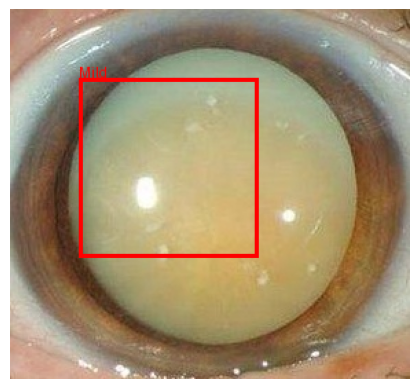

In [17]:
import torch
from torchvision import transforms, models
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Define the same transforms used in training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the ResNet18 model, without pretrained weights
model = models.resnet18(weights=None)  # No pretrained weights
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes for severity (Severe, Moderate, Mild, Normal)

# Load the pre-trained weights except for the final fully connected layer
pretrained_weights = torch.load("/content/cropped_data/cnn_cataract_classifier.pth", map_location=torch.device('cpu'))

# Remove the keys related to the fully connected layer (as its output size doesn't match)
pretrained_weights = {k: v for k, v in pretrained_weights.items() if 'fc' not in k}

# Load the weights into the model (skip the fc layer weights)
model.load_state_dict(pretrained_weights, strict=False)
model.eval()

# Define class names for severity classification
class_names = ['Severe', 'Moderate', 'Mild', 'Normal']

# Function to test a single image
def classify_image_with_bounding_box(image_path, bbox):
    # Open the image
    img = Image.open(image_path).convert("RGB")

    # Draw the bounding box
    draw = ImageDraw.Draw(img)
    draw.rectangle(bbox, outline="red", width=3)  # Draw a red bounding box

    # Crop the image to the bounding box for classification
    cropped_img = img.crop(bbox)

    # Apply the same transformations to the cropped image
    img_tensor = transform(cropped_img).unsqueeze(0)

    # Classify the image
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)  # Get the class with the highest score

    # Add the predicted class as a label near the bounding box
    label = class_names[predicted.item()]
    draw.text((bbox[0], bbox[1] - 10), label, fill="red")  # Add label above the bounding box

    # Show the image with bounding box
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()  # Show the image

    # Optionally, save the image
    img.save("/content/output_image.jpg")

# Example usage for the specified image and a bounding box (x1, y1, x2, y2)
test_image_path = "/content/cropped_data/cataract/34_0.jpg"
bbox = (50, 50, 180, 180)  # Example bounding box, replace with actual bounding box coordinates
classify_image_with_bounding_box(test_image_path, bbox)
